# Convolutional Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Import TensorFlow and other libraries

In [1]:
!pip install tensorflow-gpu==2.0.0-b1

     |████████████████████████████████| 348.9MB 59kB/s 
     |████████████████████████████████| 501kB 41.3MB/s 
     |████████████████████████████████| 3.1MB 30.8MB/s 


In [0]:
# import required libraries
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose

In [3]:
# import the training and testing images
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# preprocess the images
def preprocess(imageset):
  dataset = imageset.reshape(imageset.shape[0], 28, 28, 1).astype('float32')
  dataset /= 255.0
  dataset[dataset >= 0.5] = 1.0
  dataset[dataset < 0.5] = 0.0
  return dataset

train_images = preprocess(train_images)
test_images = preprocess(test_images)

In [0]:
# convert the data into a tensorflow compatible dataset
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    # build the inference model
    self.inference_net = tf.keras.Sequential([
      InputLayer(input_shape=(28, 28, 1)),
      Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      Flatten(),
      tf.keras.layers.Dense(latent_dim + latent_dim),
    ])

    # build the generative model
    self.generative_net = tf.keras.Sequential([
      InputLayer(input_shape=(latent_dim,)),
      Dense(units=7*7*32, activation=tf.nn.relu),
      Reshape(target_shape=(7, 7, 32)),
      Conv2DTranspose(
          filters=64,
          kernel_size=3,
          strides=(2, 2),
          padding="SAME",
          activation='relu'),
      Conv2DTranspose(
          filters=32,
          kernel_size=3,
          strides=(2, 2),
          padding="SAME",
          activation='relu'),
      Conv2DTranspose(
          filters=1, 
          kernel_size=3, 
          strides=(1, 1), 
          padding="SAME"),
    ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

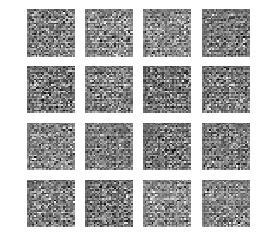

In [0]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    loss_result = -loss.result()
    print('Epoch: {}, Test set : {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    loss_result,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

### Display an image using the epoch number

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images